RNNs are types of neural nets that remember previous hidden states and pass them along to another layer.

#### When to use?
This network is applicable to sequential data, when we have to predict the new value in some series, where past knowledge must be accounted for, or classify some sequence where patterns in the data matter.

#### Architechture
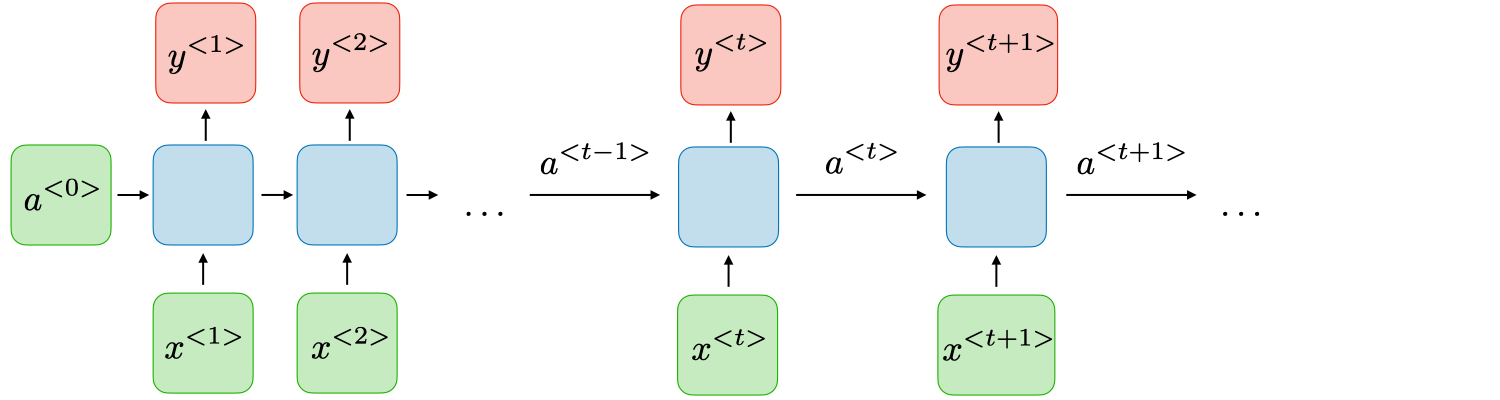


#### Disadvantages
* We are dependent on sequatial itertation -> no parallelism
* Information about old states vanishes over time
* Impossible to consider future inputs (unlike Transformers)

#### RNN implementation

We can now code it up from sratch in Pytorch. The dataset for the implementation is taken from here: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html. The first step is defining the device for carrying out calculations on:

In [1]:
import os
from torch import nn
import torch
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Reading data
Next step is mapping languages to their labels. The dataset is taken from the same tutorial. After mapping we're also going to store the number of classes (labels) in the constant $C$:

In [8]:
data_dir = './data/rnn/names'
lang2label = {
    fname.split('.')[0].lower(): torch.tensor([label], dtype=torch.long)
    for label, fname in enumerate(os.listdir(data_dir)) 
}
C = len(lang2label) # number of possible classes
list(lang2label.items())[:2], f'Number of classes: {C}'

([('arabic', tensor([0])), ('chinese', tensor([1]))], 'Number of classes: 18')

Next step is creating an array of possible symbols in order to later encode all the data:

In [12]:
import string
all_letters = string.ascii_letters + " .,;'"
print(f'e.g. "a" -> {all_letters.find("a")}')

e.g. "a" -> 0


#### Building a library for utils
These utility functions are going to be later used in the dataset class for data transformation:

In [14]:
# Creating util for decoding unicode to ASCII

import unicodedata

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(f"e.g. 'Ślusàrski' -> {unicodeToAscii('Ślusàrski')}")

e.g. 'Ślusàrski' -> Slusarski


In [17]:
# onehot encode tensors based on all_letters
# we must add an extra dimension of 1, because
# we are feeding RNN char by char and the linear 
# layer in the network expects a batch size on the input
# as well

def name2onehot(name):
    tensor = torch.zeros(len(name), 1, len(all_letters))
    for i, char in enumerate(name):
        tensor[i][0][all_letters.find(char)] = 1
    return tensor

print(name2onehot("abc"))

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])


#### Building a dataset
First off we transform our data to pytorch dataset:

In [65]:
from torch.utils.data import Dataset

class charsDataset(Dataset):
    def __init__(self):
        self.names = []
        self.labels = []
        for f in os.listdir(data_dir):
            with open(os.path.join(data_dir, f), 'r') as names_file:
                lang = f.split('.')[0].lower()
                names = [unicodeToAscii(line.rstrip()) for \
                         line in names_file.readlines()]
                for name in names:
                    try:
                        self.names.append(name2onehot(name))
                        self.labels.append(lang2label[lang])
                    except KeyError:
                        pass
        self.labels = torch.tensor(self.labels)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return (self.names[index], self.labels[index])

In [66]:
charDS = charsDataset()

# get first elemnent
charDS[1]

([tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

Then perform a $\frac{80}{20}$ train/test split on the dataset: 

In [67]:
from torch.utils.data import random_split

train_sample_size = int(.8*len(charDS))
test_sample_size = len(charDS) - train_sample_size
train, test = random_split(charDS,[train_sample_size,
                                   test_sample_size])

print(f'Train size: {len(train)}\n Test size: {len(test)}')

Train size: 16059
 Test size: 4015


#### Implementing RNN

In [41]:
class customRNN(nn.Module):
    def __init__(self, inputD, hiddenD, outputD, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hidden_size = hiddenD
        self.inputD = nn.Linear(inputD + hiddenD, hiddenD)
        self.outputD = nn.Linear(inputD + hiddenD, outputD)

    def forward(self, x, hiddenD):
        combined = torch.cat((x, hiddenD), 1)
        # next hidden state
        hid = torch.sigmoid(
            self.inputD(combined)
        )
        # output on the current + hidden previous
        out = self.outputD(combined)
        return out, hid
    
    def init_hidden(self):
        # we could do gaussian or uniform depending on what
        # type of randomization we prefer
        return nn.init.kaiming_uniform_(
            torch.empty(1,self.hidden_size)
        )

#### Training
Initialize params for training, criterion, optimizer and the model itself:

In [68]:
trainParams = {
    'lr': .001,
    'max_epochs': 5,
    'verbose': 1
}

model = customRNN(len(all_letters),2**8,C)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=trainParams['lr'])

In [73]:
from tqdm import tqdm
import numpy as np

for epoch in range(trainParams['max_epochs']):
    losses = []
    for (encName, label) in tqdm(train):
        hid = model.init_hidden()
        label = torch.unsqueeze(label,0)
        for encChar in encName:
            out, hid = model(encChar, hid)
        loss = criterion(out, label)
        losses.append(loss.item())
        optim.zero_grad()
        loss.backward()
        # prevent exploding gradients by clipping their norm to 1
        nn.utils.clip_grad_norm_(model.parameters(),1)
        optim.step()
    if epoch % trainParams['verbose'] == 0:
        print(f'Epoch {epoch} :: av. cross entropy:', np.array(losses).mean())

100%|██████████| 16059/16059 [00:30<00:00, 524.70it/s]


Epoch 0 :: av. cross entropy: 1.3804885225092483


100%|██████████| 16059/16059 [00:30<00:00, 525.45it/s]


Epoch 1 :: av. cross entropy: 1.0716802369896659


100%|██████████| 16059/16059 [00:30<00:00, 526.06it/s]


Epoch 2 :: av. cross entropy: 0.9693072737639951


100%|██████████| 16059/16059 [00:30<00:00, 523.78it/s]


Epoch 3 :: av. cross entropy: 0.8925805422644809


100%|██████████| 16059/16059 [00:30<00:00, 525.18it/s]

Epoch 4 :: av. cross entropy: 0.8349000819624468


Now we run the model on the test data. We can see that even with such a simple architecture we were able to achieve almost $80\%$ in accuracy:

In [74]:
accuratePred = 0

with torch.no_grad():
    for (encName, label) in test:
        label = torch.unsqueeze(label,0)
        hid = model.init_hidden()
        for encChar in encName:
            out, hid = model(encChar, hid)
        _, pred = torch.max(out, dim=1)
        accuratePred += bool(pred == label)

print(f'Accuracy: {accuratePred / len(test)}')

Accuracy: 0.7770859277708593


#### Model's inference
We create a function for inferencing our model on any arbitrary name represented as a string: 

In [79]:
label2lang = {v.item(): k for k, v in lang2label.items()}

def inference(name):

    # just for good etiquette we switch the model to eval mode first
    # to disable batchNorm and Dropout layers. We don't really need it
    # in our case, but it's better to have this block of code at all times
    model.eval() 
    oneHotEnc = name2onehot(name)
    with torch.no_grad():
        hidden_state = model.init_hidden()
        for char in oneHotEnc:
            output, hidden_state = model(char, hidden_state)
        _, pred = torch.max(output, dim=1)

    # switch the eval mode back to off
    model.train()
    
    return label2lang[pred.item()]

In [80]:
inference('vladislav')

'russian'

In [83]:
inference('quo')

'chinese'

In [84]:
inference('james')

'english'